In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic
import rpy2, rpy2.situation, anndata2ri


In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab


# Prep

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data"


In [7]:
%%R -o dGenesSeq,dRnaSeq,dftest

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Get genes present in Seurat object
dGenesSeq = rownames(d_fibWT@assays$RNA@data)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dftest = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


Export list of genes detected in scRNA-seq dataset.
This will be used to subset the Knowledge Graph

In [8]:
len(list(dGenesSeq))

20867

In [9]:
print(dRnaSeq.var_names)
print(dRnaSeq.obs)
print(dRnaSeq.obsm)#No DimRed were ported over
dRnaSeq

Index(['Xkr4', 'Gm37363', 'Gm6123', 'Mrpl15', 'Gm37144', 'Lypla1', 'Gm37988',
       'Tcea1', 'Rgs20', 'Atp6v1h',
       ...
       'mt-Tg', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb',
       'mt-Tt', 'partDsRedE', 'pEGFP'],
      dtype='object', length=20867)
                         orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACCCACAGCTTCCT-1  cocultWTFib     10761.0          3163      0.947867   
WT__AAACCCAGTTCGAGCC-1  cocultWTFib     15485.0          3811      1.233452   
WT__AAACGAAAGAAGGATG-1  cocultWTFib     16689.0          3775      1.270298   
WT__AAACGAAAGGAAAGGT-1  cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1  cocultWTFib     40330.0          4714      0.451277   
...                             ...         ...           ...           ...   
WT__TTTGGTTTCATTCTTG-1  cocultWTFib      9953.0          2555      0.351653   
WT__TTTGGTTTCCGTAGTA-1  cocultWTFib     15622.0          3810      1.389067   
WT__TTTGTT

AnnData object with n_obs × n_vars = 3698 × 20867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    layers: 'logcounts'

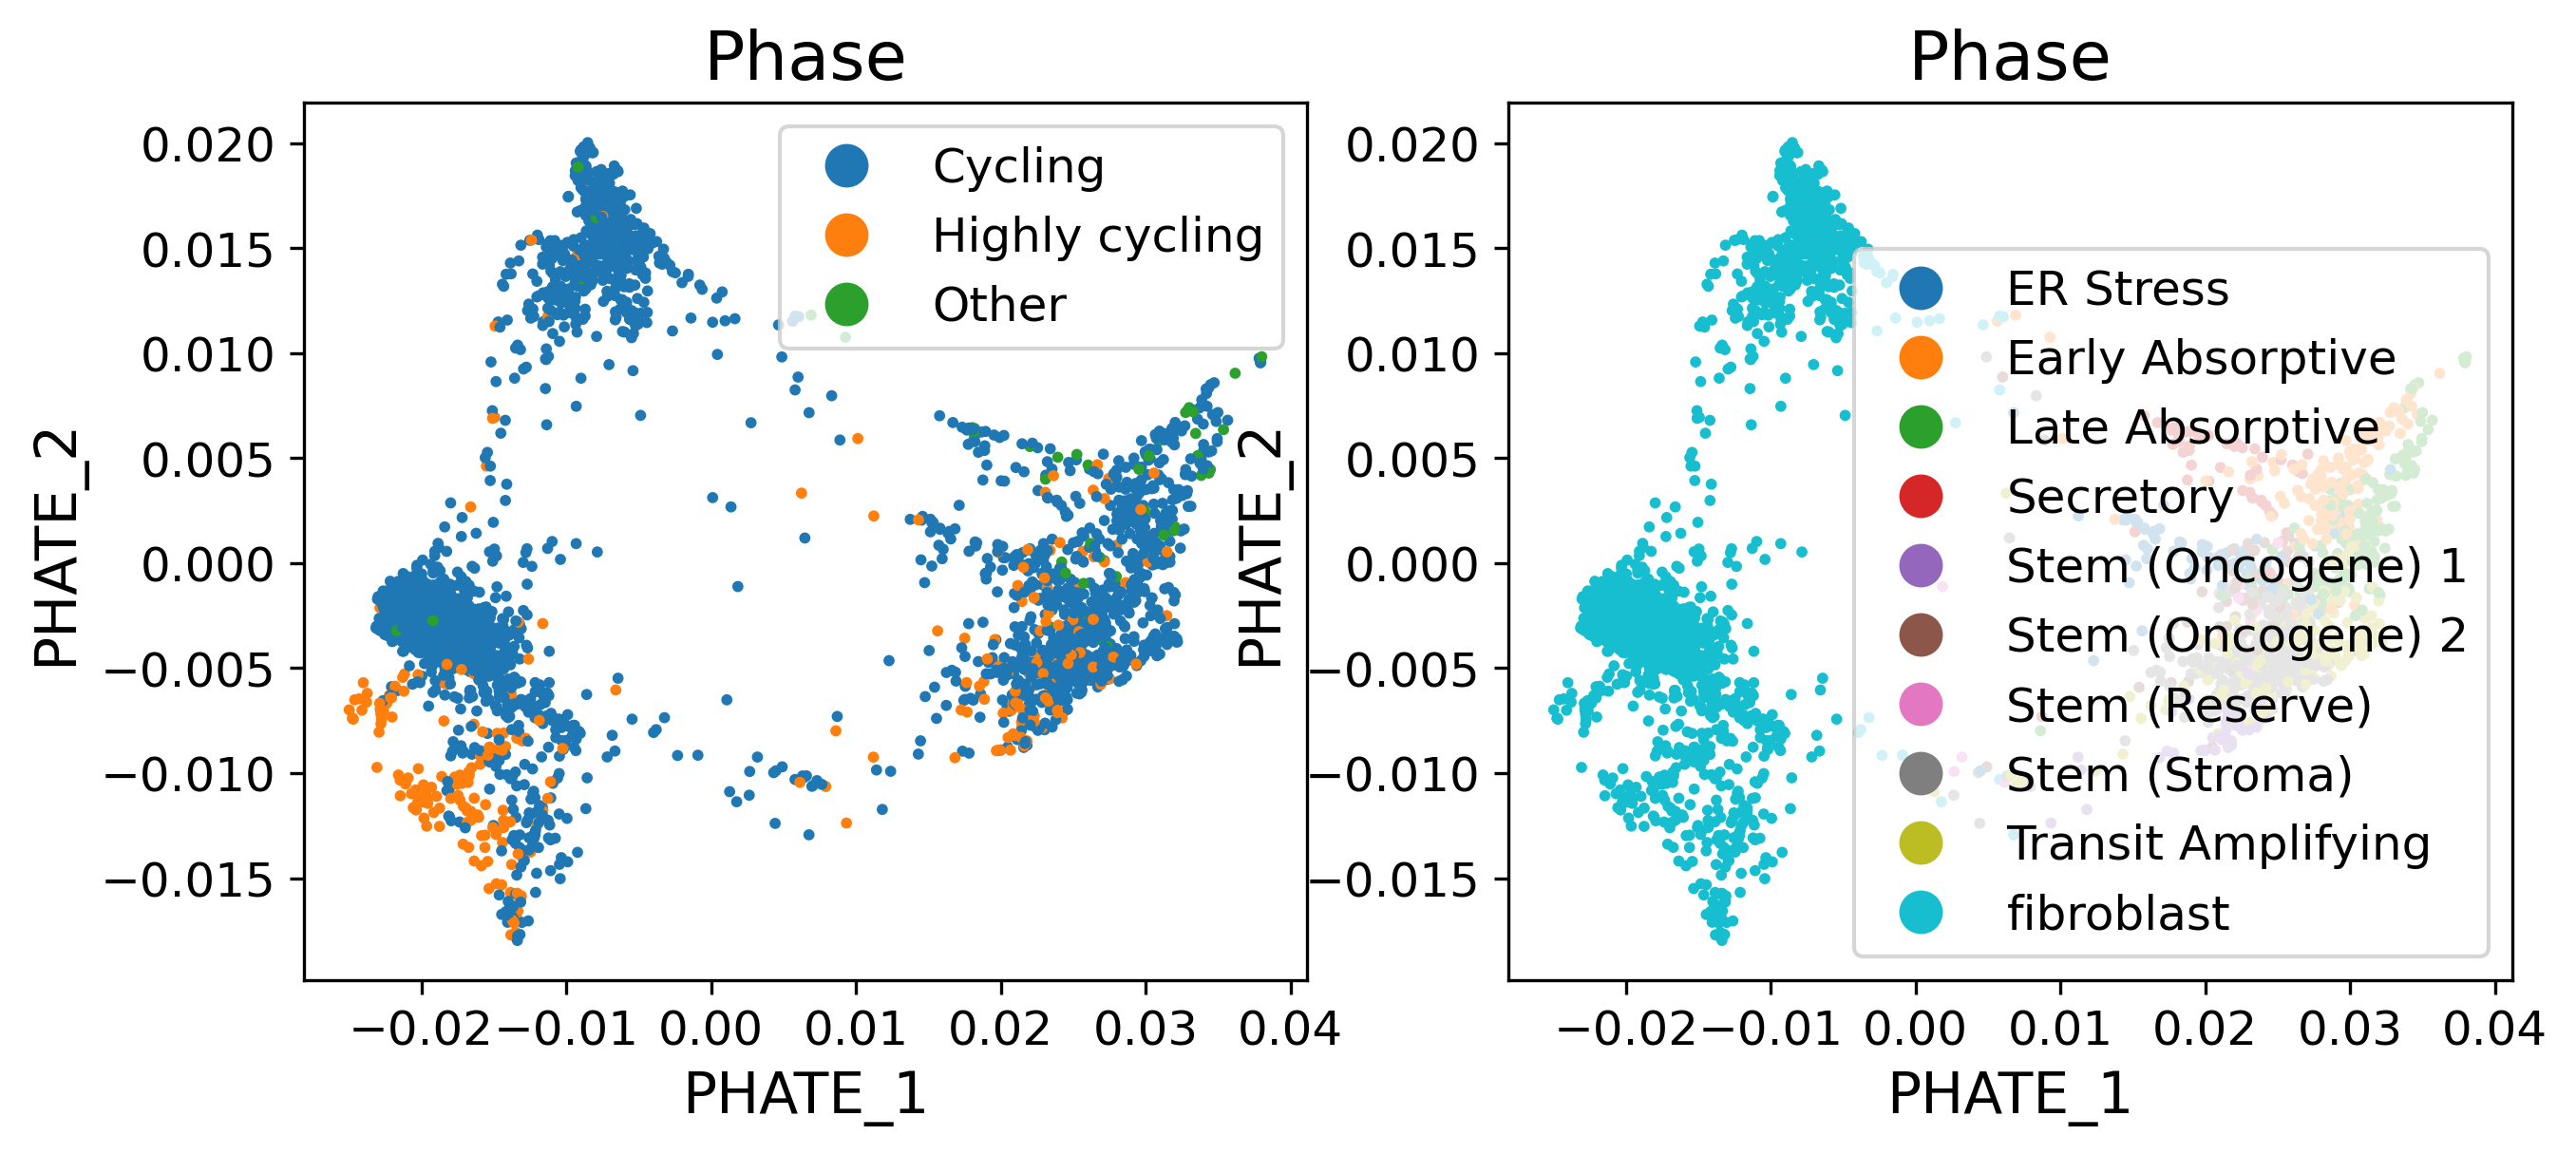

In [10]:
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dftest

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
                     title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
                     title=f"Phase", ax=ax[1])

del dftest

View data from AnnData object layers as dataframes.

In [11]:
print(dRnaSeq.to_df().head()) #Untransformed data
dRnaSeq.to_df(layer="logcounts").head() #Log transformed data to be used

                        Xkr4  Gm37363  Gm6123  Mrpl15  Gm37144  Lypla1  \
WT__AAACCCACAGCTTCCT-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACCCAGTTCGAGCC-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGAAGGATG-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGGAAAGGT-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGTTAACGA-1   0.0      0.0     0.0     7.0      0.0     0.0   

                        Gm37988  Tcea1  Rgs20  Atp6v1h  ...  mt-Tg  mt-Nd3  \
WT__AAACCCACAGCTTCCT-1      0.0    2.0    0.0      0.0  ...    0.0     1.0   
WT__AAACCCAGTTCGAGCC-1      0.0    2.0    0.0      1.0  ...    0.0     1.0   
WT__AAACGAAAGAAGGATG-1      0.0    0.0    0.0      1.0  ...    0.0     3.0   
WT__AAACGAAAGGAAAGGT-1      0.0    0.0    0.0      0.0  ...    0.0     0.0   
WT__AAACGAAAGTTAACGA-1      0.0    2.0    0.0      2.0  ...    0.0     0.0   

                        mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  mt-Cytb  mt-Tt  \
WT__AAACCCA

,Xkr4,Gm37363,Gm6123,Mrpl15,Gm37144,Lypla1,Gm37988,Tcea1,Rgs20,Atp6v1h,...,mt-Tg,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,mt-Tt,partDsRedE,pEGFP
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.050319,0.0,0.000000,...,0.0,0.657148,0.000000,2.571135,0.000000,0.000000,3.988411,0.0,0.657148,0.0
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.829238,0.0,0.498218,...,0.0,0.498218,0.000000,2.948746,1.077511,0.000000,4.079582,0.0,0.000000,0.0
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.469502,...,0.0,1.028759,0.469502,2.563713,1.028759,0.000000,4.148146,0.0,0.000000,0.0
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,2.811561,1.826475,0.000000,3.474191,0.0,0.000000,0.0
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,1.00638,0.0,0.0,0.0,0.402734,0.0,0.402734,...,0.0,0.000000,0.000000,1.698031,0.911369,0.221506,2.780384,0.0,0.000000,0.0


## KG DataBase

The integrated database is the object ingested by pykeen's *TriplesFactory*.

Then, once the scRNAseq has been loaded in, we can also subset the genes in 
this dataframe to those present in the scRNA-seq count matrix.

In [12]:
dEdgeList = pd.read_csv(f"{data_dir}/dINT_simpl.tsv", sep="\t", header=None)[[0,2]]
print(dEdgeList.shape)

#Filter rows if either column not in sequencing data
dEdgeList = dEdgeList.loc[dEdgeList[0].isin(list(dGenesSeq)) & dEdgeList[2].isin(list(dGenesSeq))]
dEdgeList

(439023, 2)


,0,2
0,Tgfb1,Tgfbr1
1,Tgfb1,Tgfbr2
2,Tgfb2,Tgfbr1
3,Tgfb2,Tgfbr2
4,Tgfb3,Tgfbr1
...,...,...
438929,Paqr8,Efhc1
438930,Teddm3,Tmem198b
438931,Teddm3,Slc7a15
438943,Cys1,Fut2


## Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [13]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                      )

In [14]:
help(magic.MAGIC())

Help on MAGIC in module magic.magic object:

class MAGIC(sklearn.base.BaseEstimator)
 |  MAGIC(knn=5, knn_max=None, decay=1, t=3, n_pca=100, solver='exact', knn_dist='euclidean', n_jobs=1, random_state=None, verbose=1)
 |  
 |  MAGIC operator which performs dimensionality reduction.
 |  
 |  Markov Affinity-based Graph Imputation of Cells (MAGIC) is an
 |  algorithm for denoising and transcript recover of single cells
 |  applied to single-cell RNA sequencing data, as described in
 |  van Dijk et al, 2018 [1]_.
 |  
 |  Parameters
 |  ----------
 |  
 |  knn : int, optional, default: 5
 |      number of nearest neighbors from which to compute kernel bandwidth
 |  
 |  knn_max : int, optional, default: None
 |      maximum number of nearest neighbors with nonzero connection.
 |      If `None`, will be set to 3 * `knn`
 |  
 |  decay : int, optional, default: 1
 |      sets decay rate of kernel tails.
 |      If None, alpha decaying kernel is not used
 |  
 |  t : int, optional, default:

In [15]:
gKG = dEdgeList.melt()["value"].drop_duplicates()
gKG

0          Tgfb1
2          Tgfb2
4          Tgfb3
12          Bmp2
17          Bmp4
           ...  
348019      Cipc
348023     Paqr8
348024    Teddm3
348026      Cys1
348512     Gpr19
Name: value, Length: 12229, dtype: object

In [16]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq.to_df(layer="logcounts"),
    genes = list(gKG)
)


Calculating MAGIC...
  Running MAGIC on 3698 cells and 20867 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/python3.9/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.57 seconds.
    Calculating affinities...
    Calculated affinities in 0.48 seconds.
  Calculated graph and diffusion operator in 3.86 seconds.
  Running MAGIC with `solver='exact'` on 12229-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.27 seconds.
Calculated MAGIC in 36.72 seconds.


In [17]:
dMagicRnaSeq

,Xkr4,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.000000,0.656307,0.127007,0.563809,0.000181,0.280992,0.297311,0.074294,0.389065,0.311515,...,0.040082,0.331522,0.222011,0.170977,0.432377,0.042551,2.561046,0.880641,0.083873,3.903000
WT__AAACCCAGTTCGAGCC-1,0.000000,0.675546,0.143338,0.621581,0.000004,0.330037,0.303913,0.048735,0.452445,0.235830,...,0.042243,0.371617,0.227084,0.139289,0.449829,0.045445,2.519365,0.852075,0.078669,3.914076
WT__AAACGAAAGAAGGATG-1,0.000000,0.592672,0.118198,0.463123,0.000037,0.248782,0.276751,0.078990,0.357646,0.293478,...,0.036208,0.318392,0.233965,0.168486,0.399834,0.068342,2.506547,0.912861,0.056959,3.858060
WT__AAACGAAAGGAAAGGT-1,0.000000,0.372321,0.450278,0.207707,0.002779,0.177921,0.179666,0.000000,0.029587,0.000000,...,0.062142,0.220886,0.163329,0.210057,0.120561,0.009209,1.835944,0.843989,0.031708,2.537386
WT__AAACGAAAGTTAACGA-1,0.001376,0.653948,0.318248,0.318942,0.010842,0.145051,0.141733,0.001585,0.106739,0.001012,...,0.046502,0.217982,0.168517,0.128289,0.052599,0.036702,1.888961,0.703151,0.053150,3.189778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000,0.484435,0.207535,0.521919,0.018330,0.387812,0.133705,0.000013,0.080484,0.000161,...,0.063694,0.146702,0.083146,0.077182,0.093548,0.006015,1.220427,0.757026,0.083483,2.117314
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.574820,0.161695,0.522491,0.000098,0.246057,0.324671,0.070717,0.390850,0.393462,...,0.050908,0.420381,0.272601,0.206184,0.447587,0.069179,2.618978,1.159805,0.069928,3.866195
WT__TTTGTTGTCGCTTGAA-1,0.000016,0.403741,0.391600,0.321726,0.003814,0.185810,0.204476,0.000129,0.051956,0.000260,...,0.054623,0.275880,0.188689,0.190669,0.076272,0.023582,1.949260,0.808865,0.059552,3.012173
WT__TTTGTTGTCTGAATCG-1,0.000000,0.772078,0.153105,0.622268,0.009051,0.404417,0.286483,0.088398,0.350856,0.033717,...,0.050711,0.323334,0.197531,0.155903,0.347547,0.037113,2.426871,0.708863,0.087412,3.921434


View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [18]:
print("Cd44" in dMagicRnaSeq.columns)
print("Fabp2" in dMagicRnaSeq.columns)
print("Epcam" in dMagicRnaSeq.columns)

True
True
True


In [19]:
print("Pdgfra" in dMagicRnaSeq.columns)
print("Cd34" in dMagicRnaSeq.columns)
print("Thy1" in dMagicRnaSeq.columns)

True
True
True


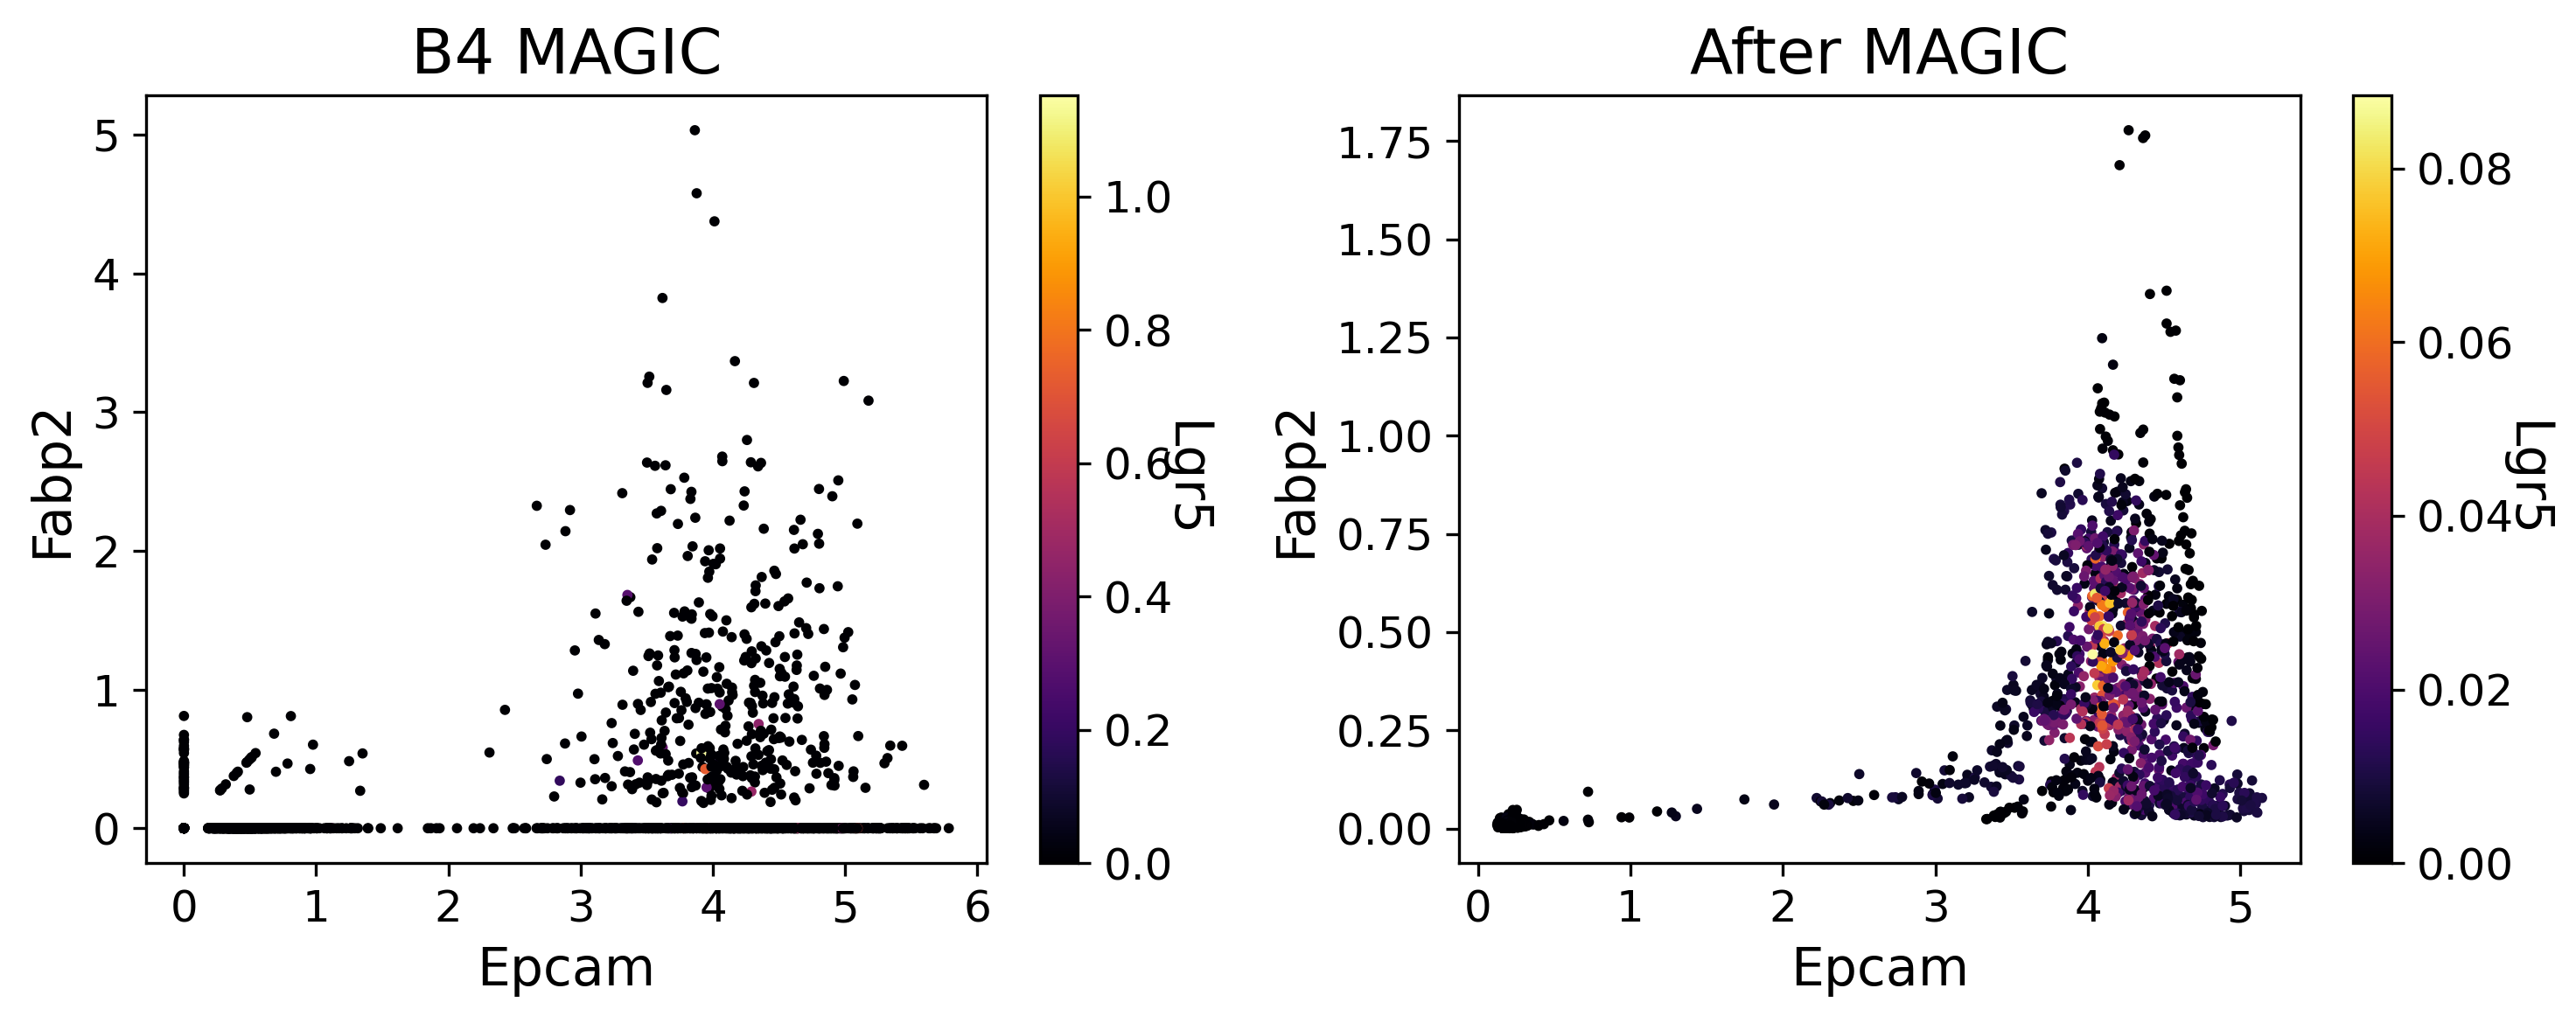

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Epcam"], y=dRnaSeq.to_df(layer="logcounts")["Fabp2"], c=dRnaSeq.to_df(layer="logcounts")["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Epcam"], y=dMagicRnaSeq["Fabp2"], c=dMagicRnaSeq["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

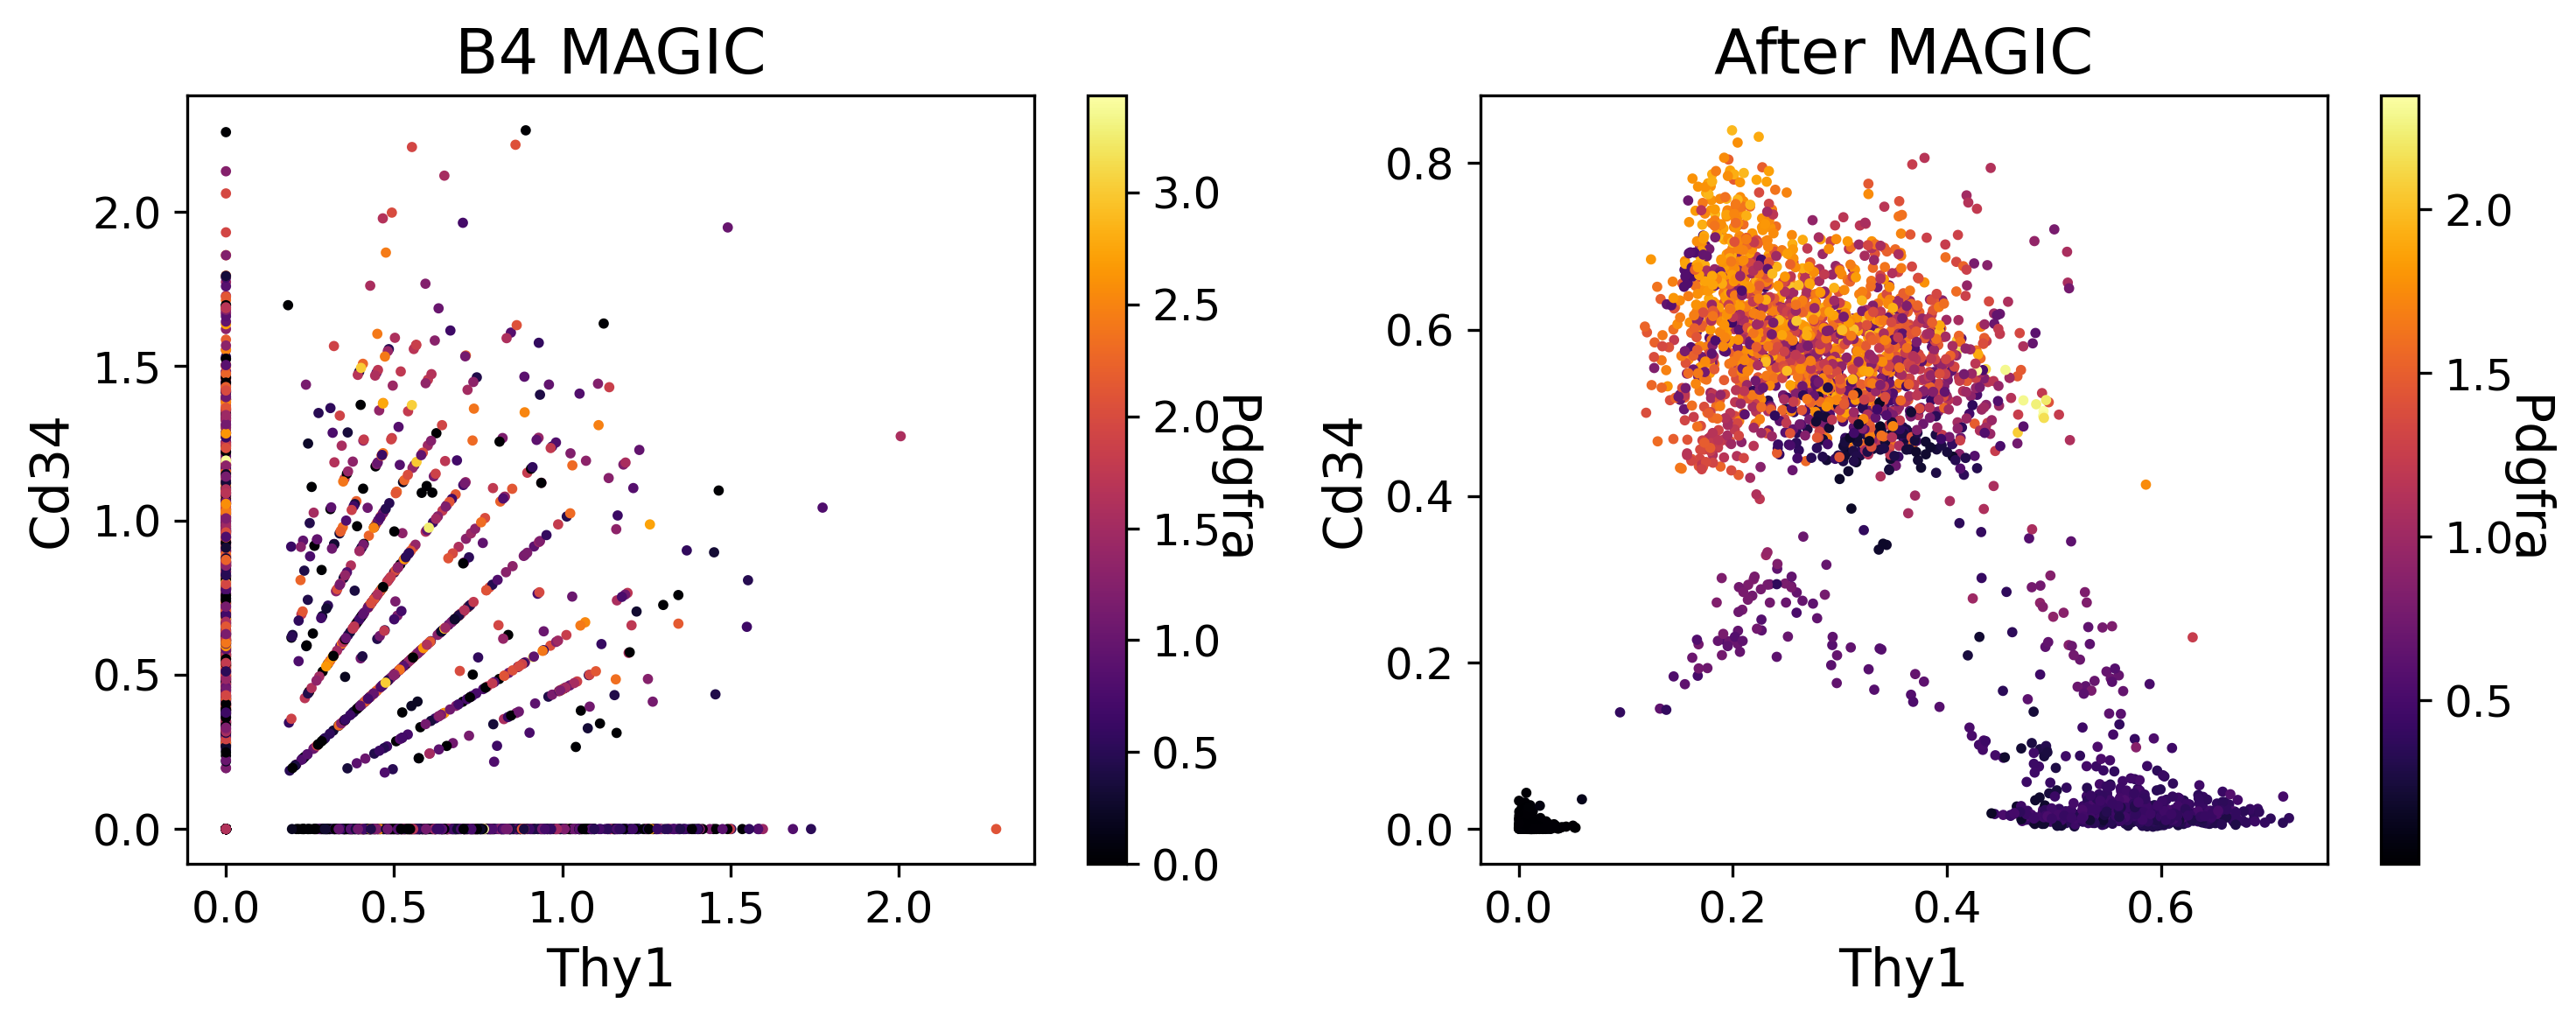

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Thy1"], y=dRnaSeq.to_df(layer="logcounts")["Cd34"], c=dRnaSeq.to_df(layer="logcounts")["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Thy1"], y=dMagicRnaSeq["Cd34"], c=dMagicRnaSeq["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [26]:
help(pd.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b

In [34]:
%%time
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
dScalRnaSeq

CPU times: user 226 ms, sys: 75.2 ms, total: 301 ms
Wall time: 300 ms


,Xkr4,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.000000e+00,0.000223,0.000043,0.000192,6.153054e-08,0.000096,0.000101,2.525857e-05,0.000132,1.059098e-04,...,0.000014,0.000113,0.000075,0.000058,0.000147,0.000014,0.000871,0.000299,0.000029,0.001327
WT__AAACCCAGTTCGAGCC-1,0.000000e+00,0.000221,0.000047,0.000203,1.295001e-09,0.000108,0.000099,1.592422e-05,0.000148,7.705802e-05,...,0.000014,0.000121,0.000074,0.000046,0.000147,0.000015,0.000823,0.000278,0.000026,0.001279
WT__AAACGAAAGAAGGATG-1,0.000000e+00,0.000202,0.000040,0.000158,1.249404e-08,0.000085,0.000094,2.691614e-05,0.000122,1.000041e-04,...,0.000012,0.000108,0.000080,0.000057,0.000136,0.000023,0.000854,0.000311,0.000019,0.001315
WT__AAACGAAAGGAAAGGT-1,0.000000e+00,0.000149,0.000180,0.000083,1.111878e-06,0.000071,0.000072,0.000000e+00,0.000012,0.000000e+00,...,0.000025,0.000088,0.000065,0.000084,0.000048,0.000004,0.000735,0.000338,0.000013,0.001015
WT__AAACGAAAGTTAACGA-1,4.992957e-07,0.000237,0.000115,0.000116,3.933088e-06,0.000053,0.000051,5.751467e-07,0.000039,3.670278e-07,...,0.000017,0.000079,0.000061,0.000047,0.000019,0.000013,0.000685,0.000255,0.000019,0.001157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000e+00,0.000191,0.000082,0.000206,7.235455e-06,0.000153,0.000053,5.036403e-09,0.000032,6.369546e-08,...,0.000025,0.000058,0.000033,0.000030,0.000037,0.000002,0.000482,0.000299,0.000033,0.000836
WT__TTTGGTTTCCGTAGTA-1,0.000000e+00,0.000195,0.000055,0.000177,3.318677e-08,0.000083,0.000110,2.395381e-05,0.000132,1.332765e-04,...,0.000017,0.000142,0.000092,0.000070,0.000152,0.000023,0.000887,0.000393,0.000024,0.001310
WT__TTTGTTGTCGCTTGAA-1,5.886442e-09,0.000151,0.000146,0.000120,1.426066e-06,0.000069,0.000076,4.824586e-08,0.000019,9.714626e-08,...,0.000020,0.000103,0.000071,0.000071,0.000029,0.000009,0.000729,0.000302,0.000022,0.001126
WT__TTTGTTGTCTGAATCG-1,0.000000e+00,0.000241,0.000048,0.000194,2.822402e-06,0.000126,0.000089,2.756604e-05,0.000109,1.051444e-05,...,0.000016,0.000101,0.000062,0.000049,0.000108,0.000012,0.000757,0.000221,0.000027,0.001223


# Approach 1-DEMD: Project cell data on gene graph

First we'll need to build and adjancency matrix from the KG. 
Then we will compute DEMD with the adjacency matrix and the distributions of 
normalised gene expression for each cell on our dataset.

## Adjacency matrix from KG

Using [networkx](https://networkx.org/documentation/stable/install.html) package.

From the integrated database, we've made a pandas dataframe that has only the 
source and target columns and then use that to make a NetworkX Graph object 
with `from_pandas_edgelist`

In [35]:
#First make graph
G = networkx.from_pandas_edgelist(dEdgeList, 0, 2)
G

In [36]:
#Adjacency matrix
AdjMat = networkx.adjacency_matrix(G)
AdjMat

/tmp/ipykernel_7880/3832294983.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  AdjMat = networkx.adjacency_matrix(G)


<12229x12229 sparse matrix of type '<class 'numpy.int64'>'
	with 347279 stored elements in Compressed Sparse Row format>

## Compute Distances

Pseudocode cell below outlining the process. Will need to create a conda environment that includes the necessary packages.

In [ ]:
from DiffusionEMD import DiffusionCheb 
 

from scipy.spatial.distance import pdist, squareform 
 

import phate  
 
 

adjacency_mat = G # networkx 
 
# Set up set of distributions to embed 
 

distributions = magic_data 
 

dc = DiffusionCheb() 
 

embeddings = dc.fit_transform(adjacency_mat, distributions) 
 
 

# L1 distance (aka cityblock distance) fast approximates the Earth Mover's Distance between distributions 
 

cell_graph = squareform(pdist(embeddings, metric='cityblock')) # shape (spots x spots, where array value is EMD between distributions) 
 

 
phate_op = phate.PHATE(knn_dist='precomputed') 
 

data_phate = phate_op.fit_transform(cell_graph) 

# Approach 2-Wavelets

According to Smita should increase biological interpretability 
(big wavelets capture a biological process/feature)

# Save data